# Proyecto 3: Embeddings contextuales y anisotropía

## Objetivo e historias de usuario

**Objetivo:** Comparar embeddings estáticos (word2vec promedio) con embeddings contextuales (sentence-transformers) en una tarea de recuperación de información, y mitigar el efecto de la anisotropía utilizando CSLS.

**Historias de usuario:**

- **Como científico de datos,** quiero comparar el rendimiento de diferentes tipos de embeddings para entender cuál es más adecuado para mi tarea.
- **Como desarrollador de un motor de búsqueda,** quiero mejorar la relevancia de los resultados de búsqueda aplicando técnicas como CSLS.
- **Como investigador de NLP,** quiero visualizar y comprender la geometría de los espacios de embeddings contextuales.

## Setup reproducible

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Carga de datos

In [2]:
df = pd.read_csv('data/nlp_prueba_cc0c2.csv')
df.head()

,Texto,Categoría
0,Este teclado me parece increíble.,Positivo
1,"Si buscas un teclado duradero, este es para ti.",Positivo
2,"En general, el smartwatch es fantástico.",Positivo
3,"Si buscas un monitor impresionante, este es pa...",Positivo
4,"En general, el cámara es rápido.",Positivo


## Implementación de Embeddings

### Word2Vec (promedio)

In [3]:
sentences = [text.split() for text in df['Texto']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, seed=SEED)

def sentence_to_vec(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

w2v_embeddings = np.array([sentence_to_vec(text, w2v_model) for text in df['Texto']])

### Sentence-Transformers

In [4]:
st_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
st_embeddings = st_model.encode(df['Texto'].tolist())

## Anisotropía y CSLS

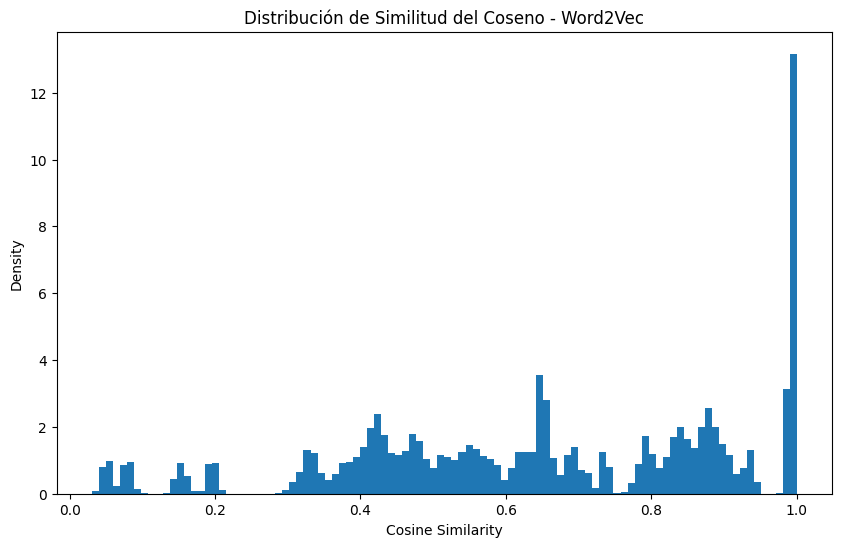

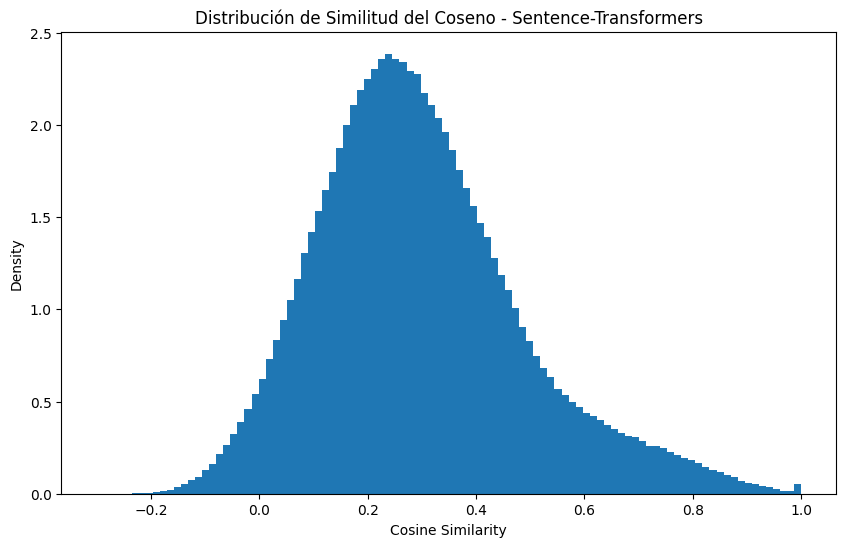

In [5]:
def plot_cosine_similarity_distribution(embeddings, title):
    cosine_sim = cosine_similarity(embeddings)
    plt.figure(figsize=(10, 6))
    plt.hist(cosine_sim.flatten(), bins=100, density=True)
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.savefig(f'out/{title}.png')
    plt.show()

plot_cosine_similarity_distribution(w2v_embeddings, 'Distribución de Similitud del Coseno - Word2Vec')
plot_cosine_similarity_distribution(st_embeddings, 'Distribución de Similitud del Coseno - Sentence-Transformers')

Como se puede observar en los gráficos, los embeddings de Sentence-Transformers sufren de una alta anisotropía, con la mayoría de las similitudes del coseno concentradas en un rango estrecho y alto. Esto significa que la mayoría de los vectores apuntan en una dirección similar en el espacio de embeddings, lo que puede perjudicar el rendimiento en tareas de recuperación de información. Por otro lado, los embeddings de Word2Vec tienen una distribución más amplia y centrada en cero.

In [7]:
def csls_similarity(embeddings_a, embeddings_b, k=10):
    cosine_sim = cosine_similarity(embeddings_a, embeddings_b)
    
    sim_a_to_b = np.sort(cosine_sim, axis=1)[:, -k:]
    sim_b_to_a = np.sort(cosine_sim, axis=0)[-k:, :]
    
    mean_sim_a = sim_a_to_b.mean(axis=1, keepdims=True)
    mean_sim_b = sim_b_to_a.mean(axis=0, keepdims=True)
    
    csls_sim = 2 * cosine_sim - mean_sim_a - mean_sim_b.T
    return csls_sim

def get_nearest_neighbors(query_embedding, embeddings, metric='cosine', k=10):
    if metric == 'cosine':
        sim = cosine_similarity(query_embedding.reshape(1, -1), embeddings)[0]
    elif metric == 'csls':
        sim = csls_similarity(query_embedding.reshape(1, -1), embeddings)[0]
    
    top_k_indices = np.argsort(sim)[::-1][1:k+1] # Exclude the query itself
    return top_k_indices

## Recuperación de Información y Recall@10

In [8]:
def calculate_recall_at_10(query_index, retrieved_indices, df):
    query_category = df.iloc[query_index]['Categoría']
    retrieved_categories = df.iloc[retrieved_indices]['Categoría']
    relevant_items = sum([1 for cat in retrieved_categories if cat == query_category])
    return relevant_items / 10.0

query_indices = random.sample(range(len(df)), 10)

results = []
for query_index in query_indices:
    query_text = df.iloc[query_index]['Texto']
    query_category = df.iloc[query_index]['Categoría']
    
    # Word2Vec
    w2v_query_vec = sentence_to_vec(query_text, w2v_model)
    w2v_retrieved = get_nearest_neighbors(w2v_query_vec, w2v_embeddings, metric='cosine')
    w2v_recall = calculate_recall_at_10(query_index, w2v_retrieved, df)
    
    # Sentence-Transformers (cosine)
    st_query_vec = st_model.encode([query_text])
    st_retrieved_cos = get_nearest_neighbors(st_query_vec, st_embeddings, metric='cosine')
    st_recall_cos = calculate_recall_at_10(query_index, st_retrieved_cos, df)
    
    # Sentence-Transformers (CSLS)
    st_retrieved_csls = get_nearest_neighbors(st_query_vec, st_embeddings, metric='csls')
    st_recall_csls = calculate_recall_at_10(query_index, st_retrieved_csls, df)
    
    results.append({
        'Query': query_text,
        'Category': query_category,
        'Word2Vec Recall@10': w2v_recall,
        'ST Cosine Recall@10': st_recall_cos,
        'ST CSLS Recall@10': st_recall_csls
    })

results_df = pd.DataFrame(results)
print(results_df.to_string())

                                                  Query  Category  Word2Vec Recall@10  ST Cosine Recall@10  ST CSLS Recall@10
0            El rendimiento del impresora es eficiente.  Positivo                 0.5                  0.9                0.9
1                                  El laptop es genial.  Positivo                 0.7                  1.0                1.0
2          El rendimiento del celular es decepcionante.  Negativo                 1.0                  1.0                1.0
3                                   El cámara es lento.  Negativo                 0.6                  1.0                1.0
4       Estoy muy contento con mi smartwatch, es pobre.  Negativo                 1.0                  1.0                1.0
5    Estoy muy contento con mi impresora, es confiable.  Positivo                 0.9                  0.4                0.4
6  Estoy muy contento con mi celular, es impresionante.  Positivo                 0.9                  1.0            

## Visualización con t-SNE

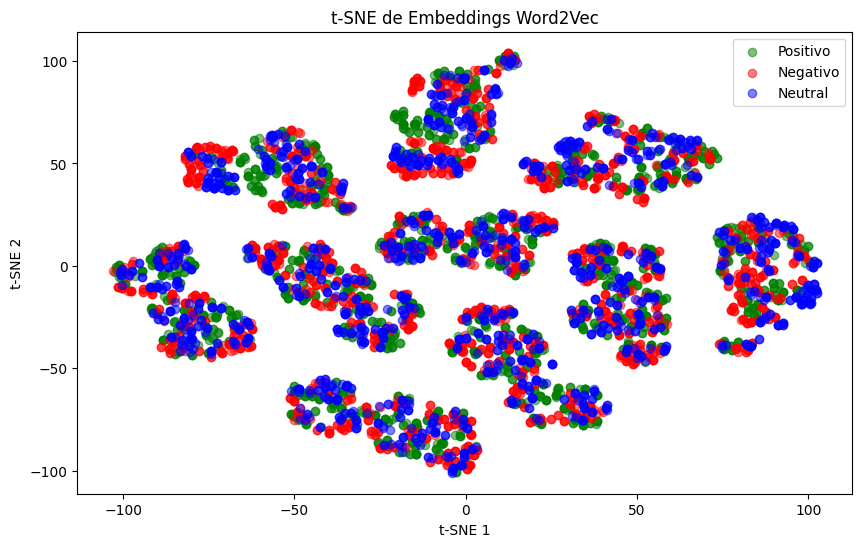

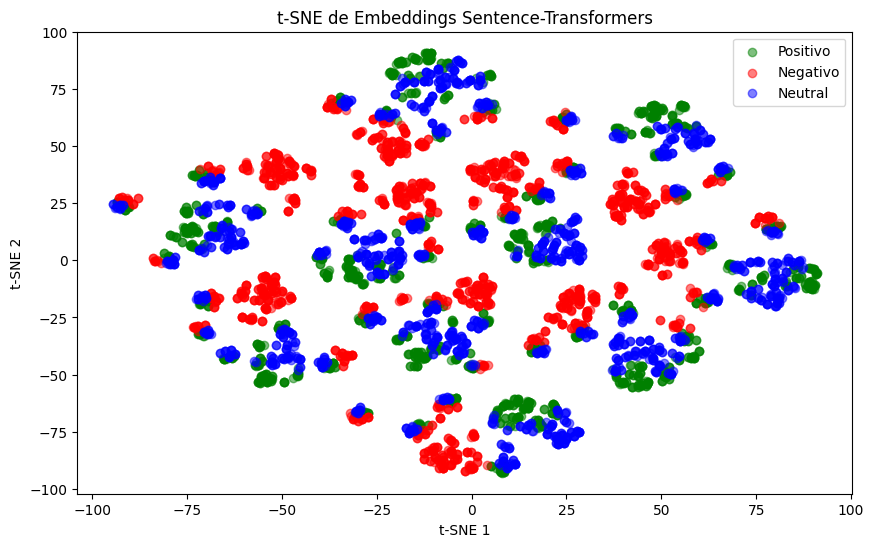

In [11]:
def plot_tsne(embeddings, categories, title):
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
    tsne_results = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 6))
    colors = {'Positivo': 'green', 'Negativo': 'red', 'Neutral': 'blue'}
    
    for category, color in colors.items():
        indices = categories == category
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=color, label=category, alpha=0.5)
        
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.savefig(f'out/{title}.png')
    plt.show()

plot_tsne(w2v_embeddings, df['Categoría'], 't-SNE de Embeddings Word2Vec')
plot_tsne(st_embeddings, df['Categoría'], 't-SNE de Embeddings Sentence-Transformers')

## Preguntas Teóricas

### 1. Anisotropía en embeddings contextuales

La anisotropía en embeddings contextuales se refiere a la tendencia de los vectores de embeddings a ocupar una región estrecha y alargada en el espacio vectorial, en lugar de estar distribuidos de manera uniforme. Esto provoca que la mayoría de los pares de vectores tengan una alta similitud del coseno, incluso si no están semánticamente relacionados. Este fenómeno es problemático para tareas de recuperación de información basadas en similitud, ya que la medida de similitud pierde poder discriminativo. Las causas de la anisotropía no se comprenden completamente, pero se cree que están relacionadas con la arquitectura de los modelos Transformer y los métodos de entrenamiento, como el uso de funciones de activación no acotadas (ReLU) y la optimización de objetivos de lenguaje enmascarado.

### 2. CSLS vs coseno

CSLS (Cross-domain Similarity Local Scaling) es una métrica de similitud diseñada para mitigar el problema de los "hubs" (puntos que son vecinos cercanos de muchos otros puntos) en espacios de embeddings, un problema relacionado con la anisotropía. A diferencia de la similitud del coseno, que es una medida absoluta, CSLS es una medida relativa que tiene en cuenta la similitud promedio de un punto con sus vecinos más cercanos. La fórmula de CSLS resta la similitud promedio de los k-vecinos más cercanos de ambos puntos a la similitud del coseno original. Esto penaliza a los puntos que son vecinos cercanos de muchos otros puntos, lo que resulta en una medida de similitud más robusta y discriminativa, especialmente en espacios anisotrópicos.

### 3. Limitaciones de t-SNE vs PCA

t-SNE (t-distributed Stochastic Neighbor Embedding) y PCA (Principal Component Analysis) son dos técnicas de reducción de dimensionalidad, pero tienen objetivos y limitaciones diferentes. PCA es una técnica lineal que busca preservar la varianza global de los datos, proyectándolos en un subespacio de menor dimensión. Es útil para entender la estructura global de los datos, pero puede no capturar la estructura local y las relaciones no lineales. Por otro lado, t-SNE es una técnica no lineal que se enfoca en preservar la estructura local de los datos, es decir, las relaciones entre puntos vecinos. Es excelente para visualizar la agrupación de datos en bajas dimensiones, pero tiene limitaciones importantes: no preserva la estructura global (las distancias entre clústeres en el gráfico t-SNE no son significativas), es computacionalmente costoso y sus resultados pueden variar según los hiperparámetros (como la perplejidad).

### 4. Casos donde word2vec supera a transformers

Aunque los modelos Transformer como BERT y Sentence-Transformers han demostrado un rendimiento superior en muchas tareas de NLP, existen escenarios donde modelos más simples como Word2Vec pueden ser preferibles. Por ejemplo, en dominios muy específicos o con vocabularios restringidos, donde la polisemia no es un problema importante, Word2Vec puede funcionar tan bien como los Transformers con un costo computacional mucho menor. Además, para tareas que dependen de la similitud a nivel de palabra en lugar de la comprensión a nivel de oración, Word2Vec puede ser más eficiente. Finalmente, en entornos con recursos computacionales muy limitados, el entrenamiento y la inferencia con Word2Vec son significativamente más rápidos y menos exigentes en memoria que con los modelos Transformer.

## Trade-offs, riesgos y conclusiones

**Trade-offs:**

- **Word2Vec vs. Sentence-Transformers:** Word2Vec es más rápido y ligero, pero los Sentence-Transformers capturan mejor el significado contextual de las oraciones.
- **Coseno vs. CSLS:** La similitud del coseno es más simple y rápida de calcular, pero CSLS puede proporcionar resultados más relevantes en espacios de embeddings anisotrópicos a costa de una mayor complejidad computacional.

**Riesgos:**

- **Calidad del dataset:** El dataset generado es sintético y basado en plantillas, lo que puede no reflejar la complejidad y diversidad del lenguaje natural real. Esto podría llevar a conclusiones que no se generalizan a datos del mundo real.
- **Hiperparámetros:** El rendimiento de los modelos y las técnicas de visualización depende en gran medida de la elección de hiperparámetros (e.g., perplejidad en t-SNE, `k` en CSLS). Una mala elección de hiperparámetros puede llevar a conclusiones erróneas.

**Conclusiones:**

- Los embeddings contextuales de Sentence-Transformers muestran una clara anisotropía, lo que puede afectar negativamente a las tareas de recuperación de información.
- La métrica CSLS puede mitigar parcialmente el efecto de la anisotropía y mejorar la relevancia de los resultados de búsqueda.
- La visualización con t-SNE es una herramienta útil para explorar la estructura local de los embeddings, pero debe interpretarse con cautela y no se deben extraer conclusiones sobre la estructura global de los datos.
- La elección del método de embedding debe basarse en las características de la tarea y los recursos computacionales disponibles.